# Planètes 
Notebook pour faire quelques tests, comparer les schémas d'intégration etc.

In [1]:
from examples.solar import SolarSystem
import importlib
import numpy as np
import pygalaxy
from docopt import docopt
from pygalaxy.barnes_hut_array import compute_energy

# Premier test avec tous les schémas

In [2]:
# last 3 are symplectics
schemes = ['RK4', 'ADB6', 'Euler_symplectic','Stormer_verlet','Optimized_815']

In [3]:
from time import time

# importing function to compute the energy
from utils import get_energy_solar, get_energy_planet # get_center_of_mass

ImportError: cannot import name 'get_center_of_mass' from 'utils' (/home/paul/Documents/cours/3A/MAP551/MAP551/projet/python-galaxy/utils.py)

In [ ]:
# je suis a peu près sûr que le calcul est faux
times = np.zeros(len(schemes))

# args en plus 
args = {
    'theta' : 0.5
}
# simu parameters
dt_in_days = 1
number_of_steps = 1000

print('Batch of simulations with dt = {} days and for {} steps.'.format(dt_in_days,number_of_steps))
for i,scheme in enumerate(schemes) :
    sim = SolarSystem(dt = dt_in_days*pygalaxy.physics.day_in_sec, display_step=number_of_steps,
                      scheme = scheme, args_method = args)
    init_energy = get_energy_solar(sim.particles,sim.mass, verbose = False)
    t1=time()
    sim.next() # in theory, it already computes energy inside next() (inside the scheme used in fact)
    t2=time()
    # see if we can get it and plot the energy as a function of time
    final_energy = get_energy_solar(sim.particles, sim.mass, verbose = False)
    print('{} : {} secs. Energy final/init: {}'.format(scheme, "{:e}".format(t2-t1),"{:e}".format(final_energy/init_energy)))
   

Changer le nombre de pas ne change pas grand chose (étrange ?).

## Plot des trajectoires des planètes

In [ ]:
# je suis a peu près sûr que le calcul est faux
times = np.zeros(len(schemes))

# simu parameters
dt_in_days = 1
number_of_steps = 1000

print('Batch of simulations with dt = {} days and for {} steps.'.format(dt_in_days,number_of_steps))
saving_lists=[]

for i,scheme in enumerate(schemes) :
    sim = SolarSystem(dt = dt_in_days*pygalaxy.physics.day_in_sec, display_step=number_of_steps,
                      scheme = scheme)
    saving_lists.append(sim.next(return_pos = True)) # in theory, it already computes energy inside next() (inside the scheme used in fact)


Batch of simulations with dt = 1 days and for 1000 steps.


Schéma : RK4


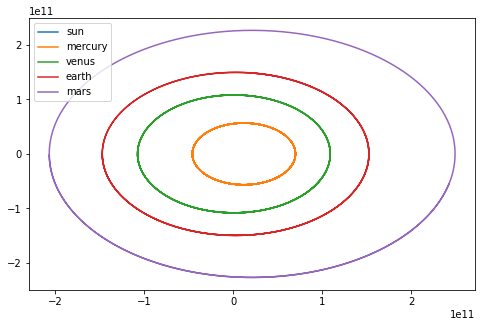

Schéma : ADB6


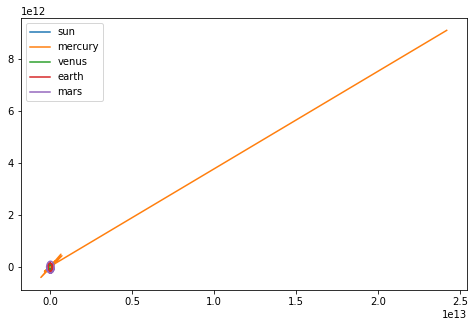

Schéma : Euler_symplectic


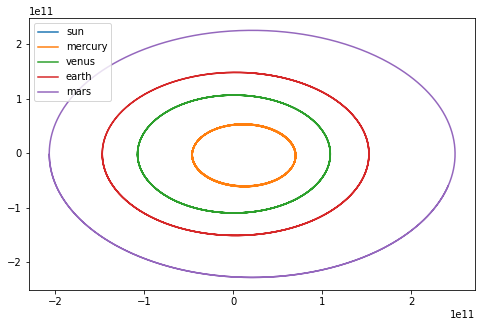

Schéma : Stormer_verlet


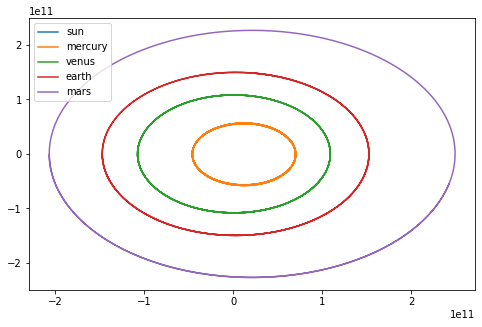

Schéma : Optimized_815


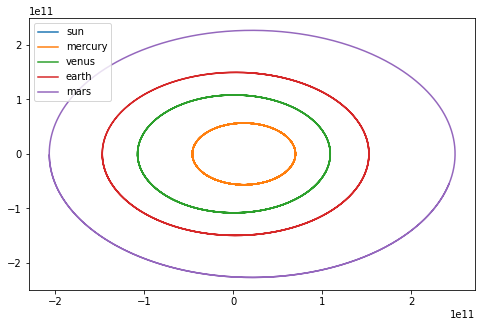

In [6]:
""" sous forme de scatter
import matplotlib.pyplot as plt
for k in range(len(saving_lists)):
    coords_list = saving_lists[k]
    fig, ax = plt.subplots(figsize=(8,5)) 
    for coords in coords_list :
        plt.scatter(coords[:, 0], coords[:, 1], c='black', s=1)
    plt.show()
"""
names = ['sun', 'mercury', 'venus', 'earth', 'mars']

import matplotlib.pyplot as plt
for k in range(len(saving_lists)):
    print('Schéma : {}'.format(schemes[k]))
    fig, ax = plt.subplots(figsize=(8,5)) 
    pos_ = saving_lists[k]
    shape = pos_.shape
    positions = np.moveaxis(saving_lists[k], 0, -1)
    for planet in range(len(positions)):

        plt.plot(positions[planet][0],positions[planet][1], label = names[planet])# [nb_steps, nb_planets,2] -> [nb_planets,2,nb_steps]
    plt.legend(loc='best')
    plt.show()


# Plotting de l'énergie en fonction du temps 

  

mercury : 


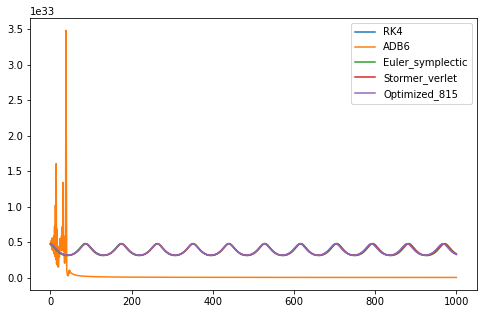

venus : 


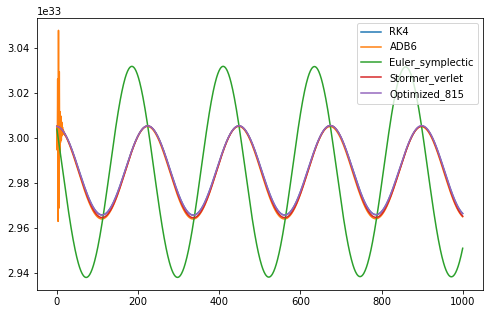

earth : 


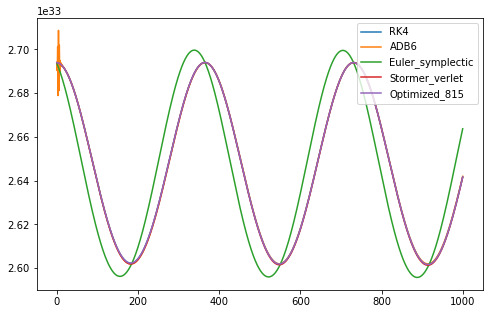

mars : 


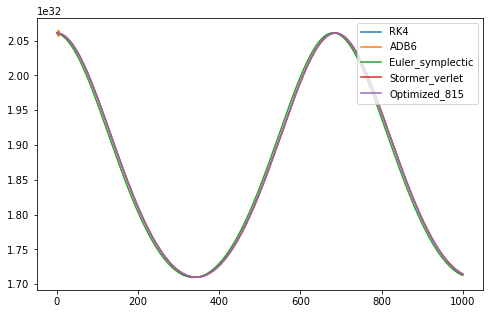

In [7]:
names = ['sun', 'mercury', 'venus', 'earth', 'mars']
masses = np.array([  1.989e30, # sun
                      .33011e24, #mercury
                      4.8675e24, #venus
                       5.972e24, #earth
                      6.4171e23, #mars
                    #  1898.19e24, #jupiter
                    #   568.34e24, #saturn
                    #   86.813e24, #uranus
                    #  102.413e24, #neptune 
                    ]) 

energies_all_schemes = np.zeros((len(names),len(schemes),number_of_steps))
for k in range(len(saving_lists)):
    pos_ = saving_lists[k]
    shape = pos_.shape #[nb_steps,nb_planets,2]
    #positions = np.moveaxis(saving_lists[k], 1, 0) #[nb_planets,nb_steps,2]
    list_energies = np.zeros((shape[1],shape[0])) # [nb_planets, nb_steps]
    for step in range(shape[0]):
        xs, ys = pos_[step][0][0],pos_[step][0][1]
        for idx_planet in range(1,shape[1]): # sun in first pos
            xp, yp, mass =  pos_[step][idx_planet][0],pos_[step][idx_planet][1], masses[idx_planet]
            energies_all_schemes[idx_planet,k,step]=get_energy_planet(xp, yp, mass, xs, ys)
# energies_all_scheme contains energy ordered by planet, then schemes then time step

Time = np.linspace(0,number_of_steps*dt_in_days,number_of_steps)

for idx_planet in range(1,shape[1]):
    fig, ax = plt.subplots(figsize=(8,5)) 
    # we don't plot for the sun
    print('{} : '.format(names[idx_planet]))
    for scheme in range(len(schemes)):
        plt.plot(Time,energies_all_schemes[idx_planet][scheme], label=schemes[scheme])
    plt.legend(loc='best')
    plt.show()
    

RK4 : 


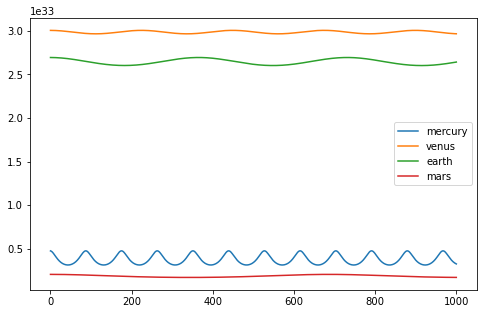

ADB6 : 


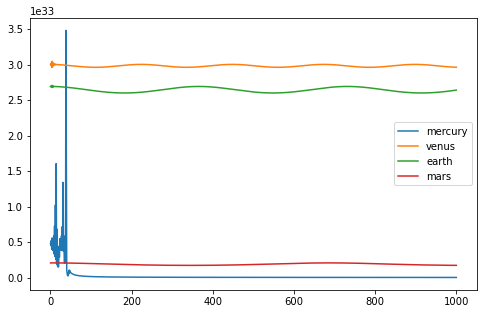

Euler_symplectic : 


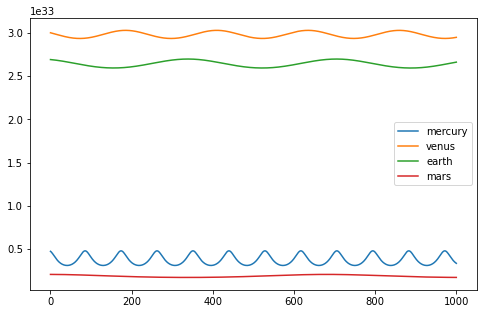

Stormer_verlet : 


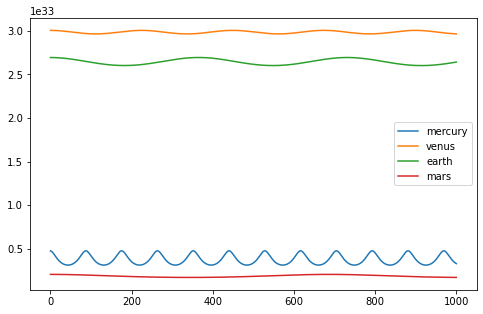

Optimized_815 : 


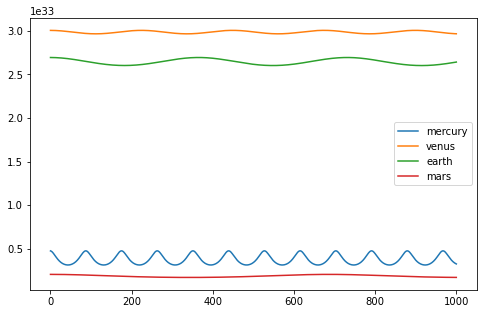

In [8]:
Time = np.linspace(0,number_of_steps*dt_in_days,number_of_steps)

for scheme in range(len(schemes)):
    fig, ax = plt.subplots(figsize=(8,5)) 
    # we don't plot for the sun
    print('{} : '.format(schemes[scheme]))
    for idx_planet in range(1,shape[1]):
        plt.plot(Time,energies_all_schemes[idx_planet][scheme], label=names[idx_planet])
    plt.legend(loc='best')
    plt.show()